In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [20]:
def show_tensor_images(image_tensor, num_images = 25, size = (1,28,28)):
  image_unflat = image_tensor.detach().cpu().view(-1,*size)
  image_grid = make_grid(image_unflat[:num_images], nrow=5)
  plt.imshow(image_grid.permute(1, 2, 0).squeeze())
  plt.show()

In [3]:
def get_generator_block(input_dim, output_dim):

  return nn.Sequential(
      nn.Linear(input_dim, output_dim),
      nn.BatchNorm1d(output_dim),
      nn.ReLU(inplace=True)
  )

In [4]:
class Generator(nn.Module):

  def __init__(self,z_dim=10, im_dim=784, hidden_dim=128):
    super().__init__()
    self.gen = nn.Sequential(
        get_generator_block(z_dim, hidden_dim),
        get_generator_block(hidden_dim, hidden_dim * 2),
        get_generator_block(hidden_dim * 2, hidden_dim * 4),
        get_generator_block(hidden_dim * 4, hidden_dim * 8),
        nn.Linear(hidden_dim * 8, im_dim),
        nn.Sigmoid()
    )

  def forward(self, noise):
    return self.gen(noise)

  def get_gen(self):
    return self.gen

In [5]:
def get_noise(n_samples, z_dim = 10, device = "cpu"):
  return torch.randn(n_samples, z_dim, device=device)

In [6]:
def get_discriminator_block(input_dim, output_dim):
  return nn.Sequential(
      nn.Linear(input_dim, output_dim),
      nn.LeakyReLU(0.2)
  )

In [7]:
class Discriminator(nn.Module):
  def __init__(self,im_dim = 784, hidden_dim = 128):
    super().__init__()

    self.disc = nn.Sequential(
        get_discriminator_block(im_dim, hidden_dim * 4),
          get_discriminator_block(hidden_dim * 4, hidden_dim * 2),
          get_discriminator_block(hidden_dim * 2, hidden_dim),
          nn.Linear(hidden_dim,1)
    )

  def forward(self,image):
    return self.disc(image)

  def get_disc(self):
    return self.disc


In [8]:
criterion = nn.BCEWithLogitsLoss()
n_epochs = 200
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.00001
device = "cuda"
dataloader = DataLoader(
    MNIST(".",download=True, transform=transforms.ToTensor()),
    batch_size = batch_size,
    shuffle = True
)


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [9]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(),lr=lr)
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

In [11]:
def get_disc_loss(gen, disc, criterion, real, num_images, z_dim, device):
  noise = get_noise(num_images, z_dim,device=device)
  fake_images = gen(noise)
  pred = disc(fake_images.detach())
  loss = criterion(pred, torch.zeros(num_images,1,device=device))
  pred_real = disc(real)
  loss_real = criterion(pred_real, torch.ones(num_images,1,device=device))
  disc_loss = (loss + loss_real) / 2

  return disc_loss

In [15]:
def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):
  noise = get_noise(num_images, z_dim, device=device)
  fake_images = gen(noise)
  pred = disc(fake_images)
  loss = criterion(pred, torch.ones(num_images,1,device=device))
  return loss

Step 500: Generator loss: 1.7047079012393949, discriminator loss: 0.29592212861776357


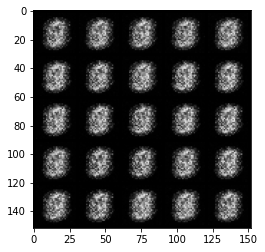

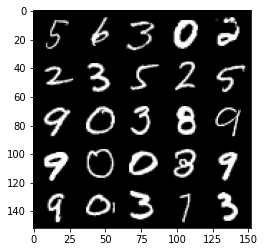

Step 1000: Generator loss: 1.99568018436432, discriminator loss: 0.17039731842279446


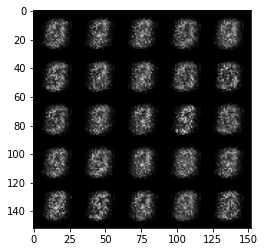

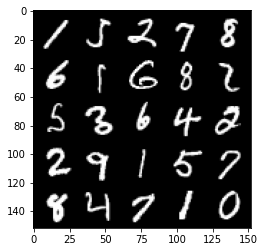

Step 1500: Generator loss: 1.618843511819839, discriminator loss: 0.23966606277227392


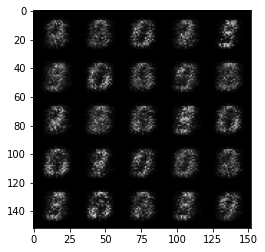

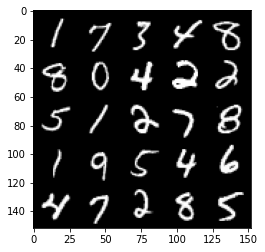

Step 2000: Generator loss: 1.5496996247768395, discriminator loss: 0.23489885559678073


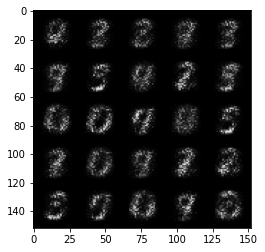

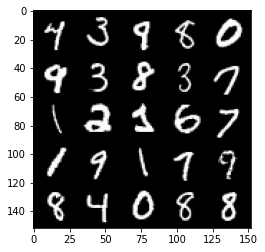

Step 2500: Generator loss: 1.830643048524858, discriminator loss: 0.1795531994849445


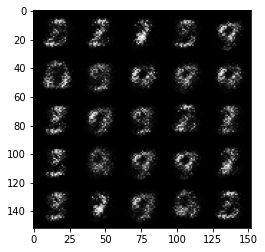

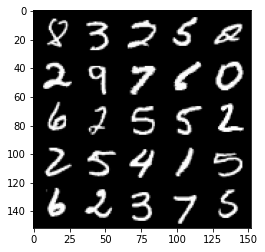

Step 3000: Generator loss: 2.2869706008434276, discriminator loss: 0.1379586485773325


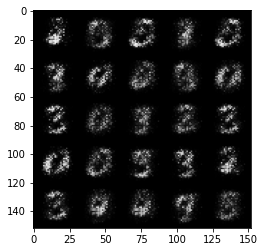

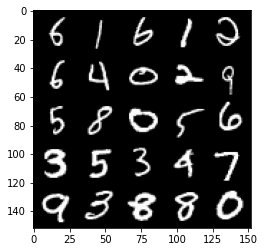

Step 3500: Generator loss: 2.5756313567161566, discriminator loss: 0.13773148161172882


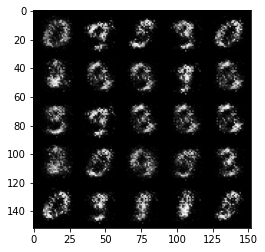

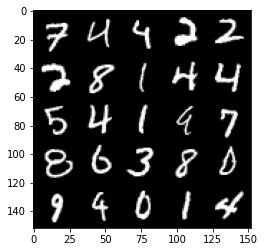

Step 4000: Generator loss: 2.9225454897880545, discriminator loss: 0.1134404349327087


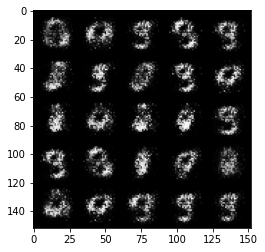

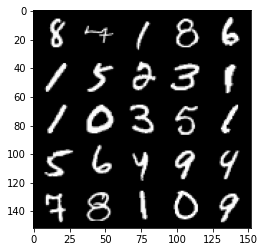

Step 4500: Generator loss: 3.2936585125923123, discriminator loss: 0.08588280555605891


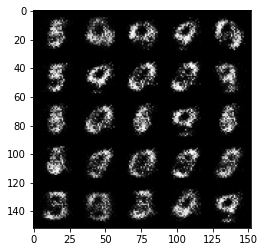

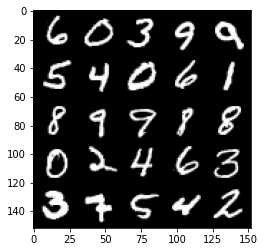

Step 5000: Generator loss: 3.444453350067136, discriminator loss: 0.0759693700671196


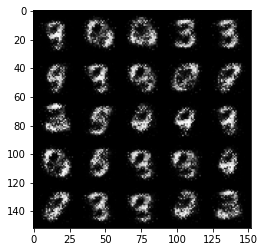

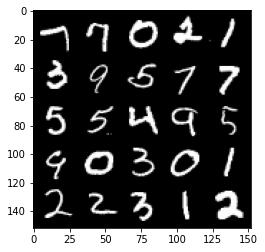

Step 5500: Generator loss: 3.5809977436065656, discriminator loss: 0.07376936906576159


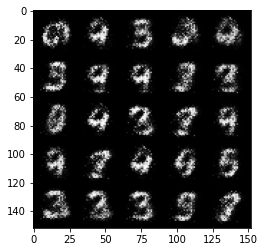

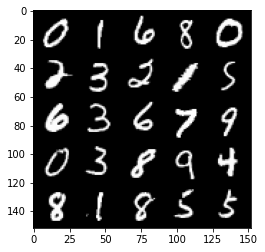

Step 6000: Generator loss: 3.7860392131805396, discriminator loss: 0.06250564325600859


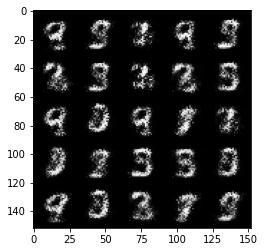

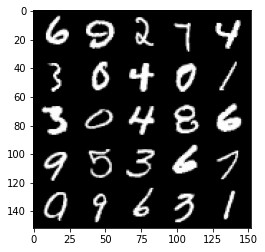

Step 6500: Generator loss: 3.8145520343780532, discriminator loss: 0.06305625890940435


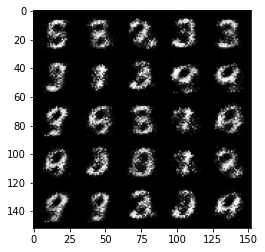

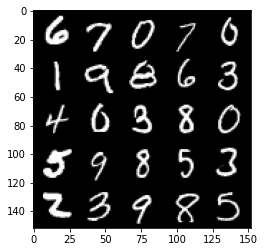

Step 7000: Generator loss: 4.141448165893552, discriminator loss: 0.05940388005226849


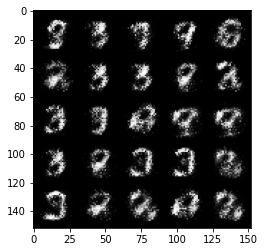

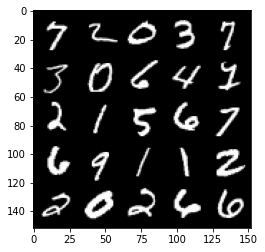

Step 7500: Generator loss: 3.9707651729583735, discriminator loss: 0.06588506957888608


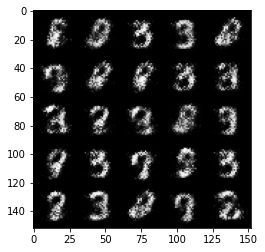

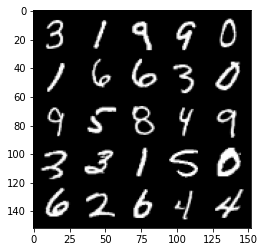

Step 8000: Generator loss: 4.137530395507812, discriminator loss: 0.05217318750172854


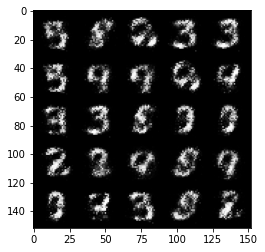

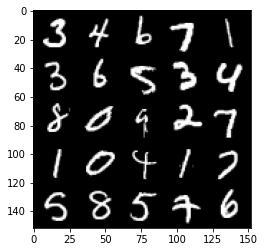

Step 8500: Generator loss: 4.207883274555209, discriminator loss: 0.05528384825587272


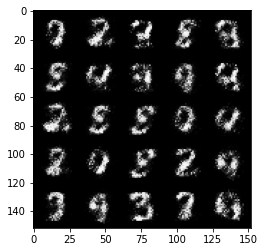

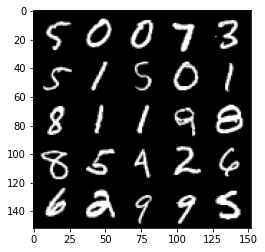

Step 9000: Generator loss: 4.142334596633914, discriminator loss: 0.06065806073322892


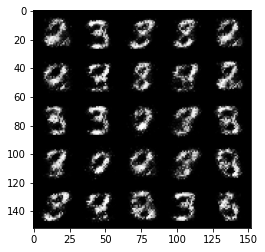

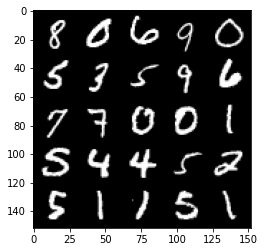

Step 9500: Generator loss: 4.29064535331726, discriminator loss: 0.062273473814129815


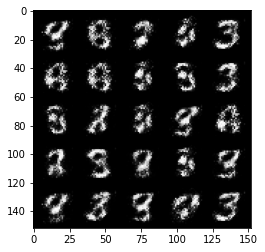

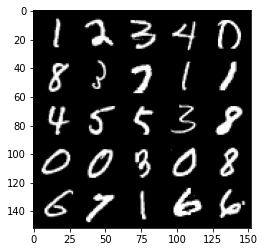

Step 10000: Generator loss: 4.221706401824954, discriminator loss: 0.0646157937720418


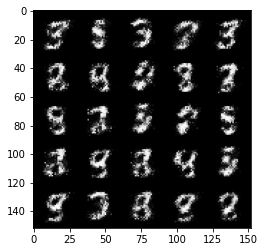

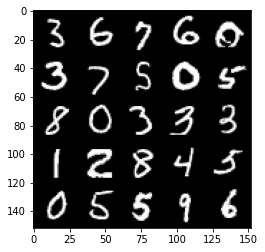

Step 10500: Generator loss: 4.475581567764285, discriminator loss: 0.06367331822216514


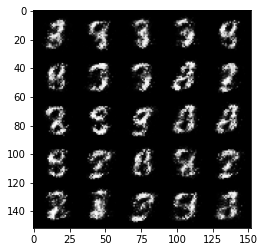

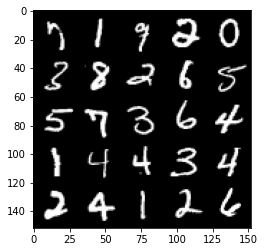

Step 11000: Generator loss: 4.267713064670558, discriminator loss: 0.07446184797585019


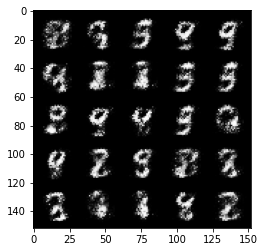

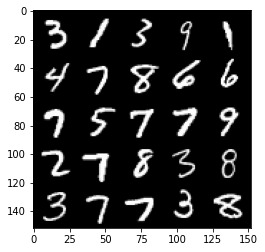

Step 11500: Generator loss: 3.9376954088211025, discriminator loss: 0.08640725480020042


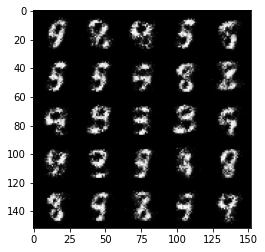

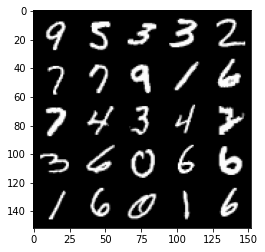

Step 12000: Generator loss: 3.8212245087623566, discriminator loss: 0.09256511076539752


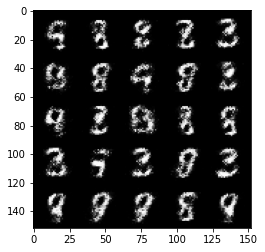

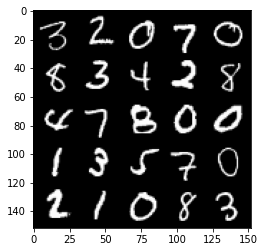

Step 12500: Generator loss: 4.030249633312226, discriminator loss: 0.08021131678670644


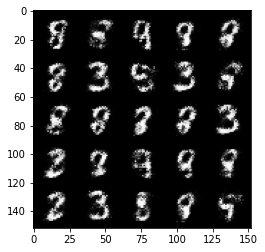

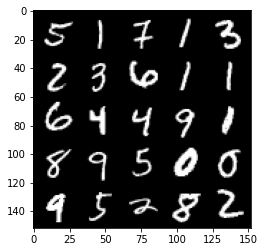

Step 13000: Generator loss: 4.033549903869629, discriminator loss: 0.08578495952486986


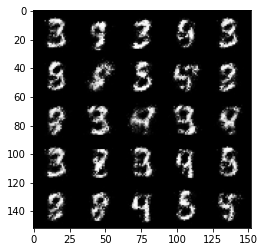

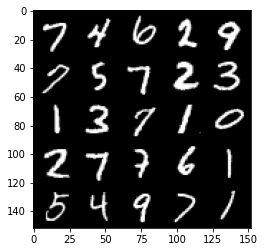

Step 13500: Generator loss: 3.8060975427627595, discriminator loss: 0.09306353081017729


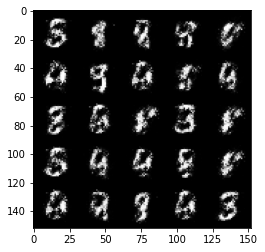

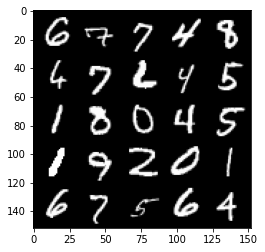

Step 14000: Generator loss: 3.982965654850007, discriminator loss: 0.08921523308008908


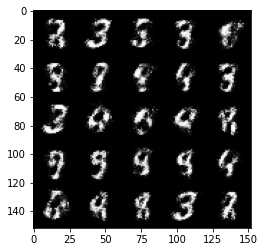

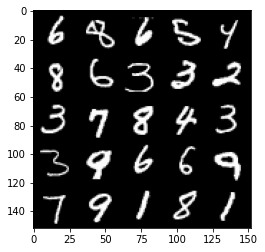

Step 14500: Generator loss: 3.9404085812568685, discriminator loss: 0.10008681569248432


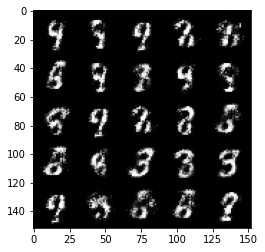

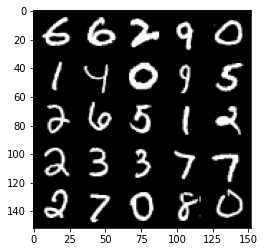

Step 15000: Generator loss: 3.7185666389465344, discriminator loss: 0.11606463549286127


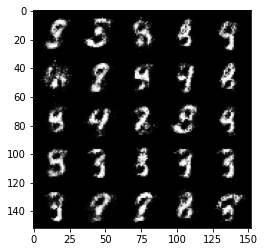

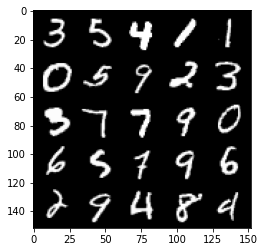

Step 15500: Generator loss: 3.6869062933921835, discriminator loss: 0.10478117105364802


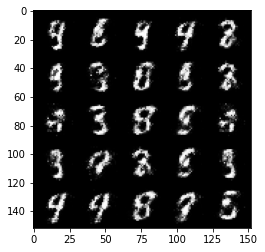

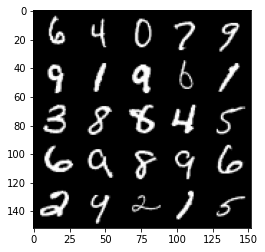

Step 16000: Generator loss: 3.621115037441252, discriminator loss: 0.12027109383046622


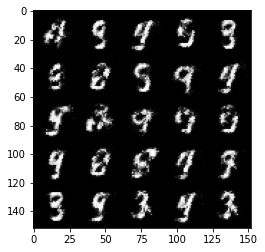

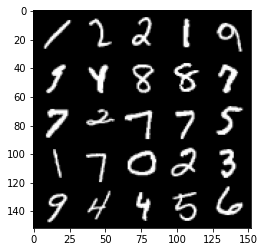

Step 16500: Generator loss: 3.614152122497556, discriminator loss: 0.12912946332991132


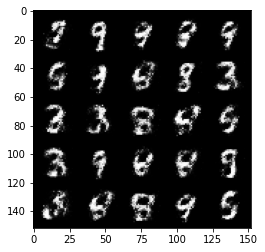

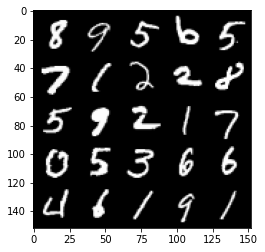

Step 17000: Generator loss: 3.490091510772704, discriminator loss: 0.13547690229117876


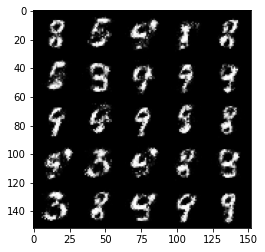

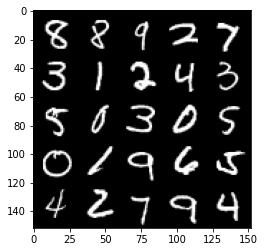

Step 17500: Generator loss: 3.4837095980644235, discriminator loss: 0.12711389143764973


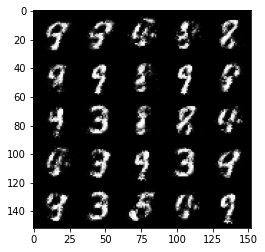

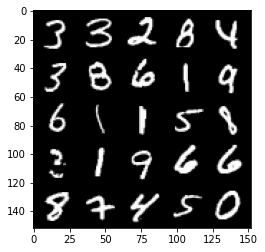

Step 18000: Generator loss: 3.3716117844581595, discriminator loss: 0.13689018358290186


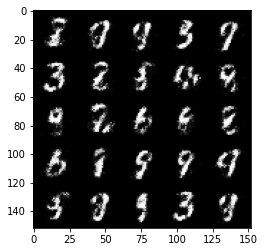

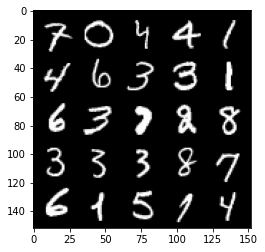

Step 18500: Generator loss: 3.3754841551780697, discriminator loss: 0.1495507596954704


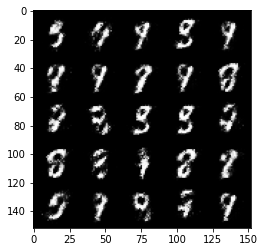

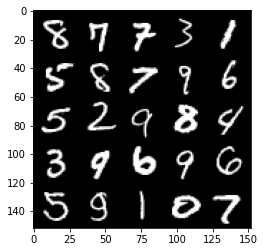

Step 19000: Generator loss: 3.35910699081421, discriminator loss: 0.13367754192650308


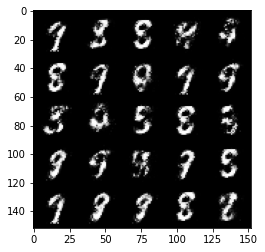

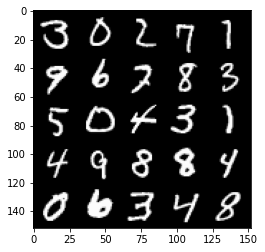

Step 19500: Generator loss: 3.4562434520721435, discriminator loss: 0.1341696307063102


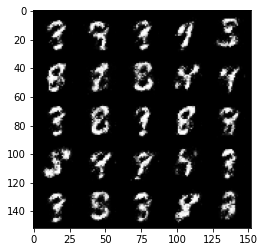

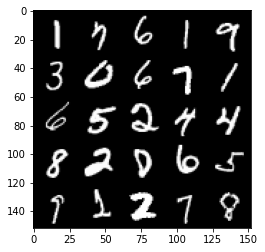

Step 20000: Generator loss: 3.3459361000061016, discriminator loss: 0.13666474485397342


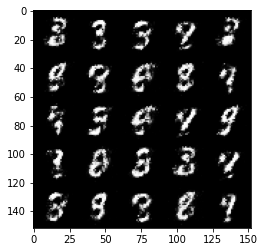

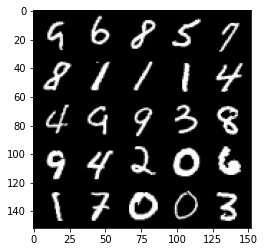

Step 20500: Generator loss: 3.3309392218589786, discriminator loss: 0.15116820521652694


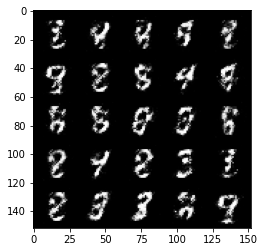

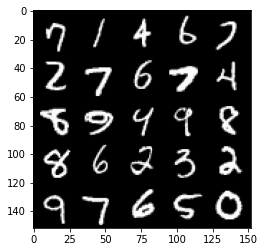

Step 21000: Generator loss: 3.285393250465397, discriminator loss: 0.16229505588114276


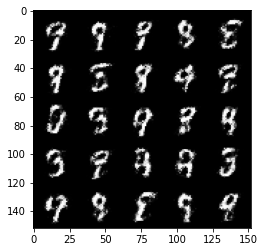

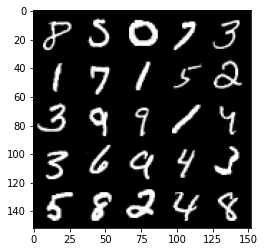

Step 21500: Generator loss: 3.0983329095840477, discriminator loss: 0.17567954263091085


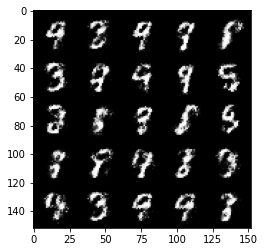

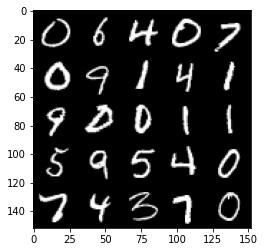

Step 22000: Generator loss: 3.228794465065006, discriminator loss: 0.15139995221793648


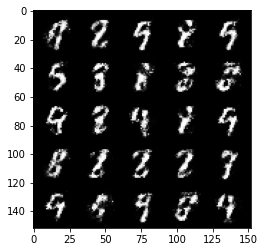

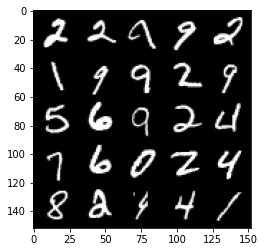

Step 22500: Generator loss: 3.135331313610074, discriminator loss: 0.16333612236380574


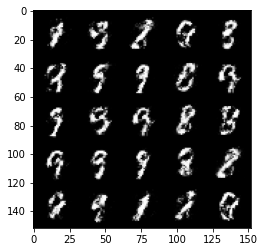

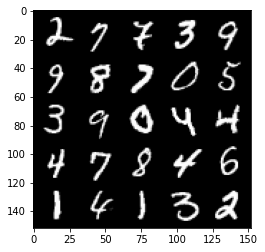

Step 23000: Generator loss: 3.104886930942535, discriminator loss: 0.18525871665775773


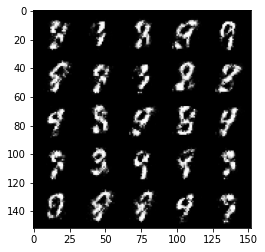

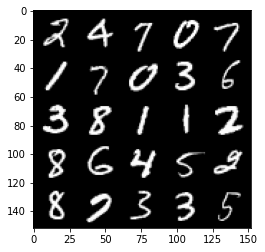

Step 23500: Generator loss: 2.974270776271821, discriminator loss: 0.19545868282020093


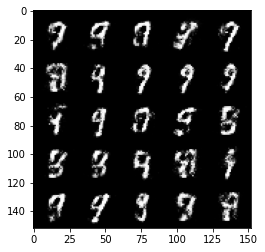

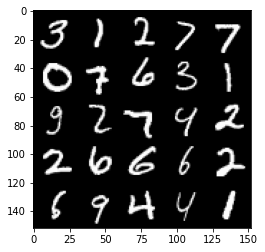

Step 24000: Generator loss: 2.9488574533462493, discriminator loss: 0.19086039064824575


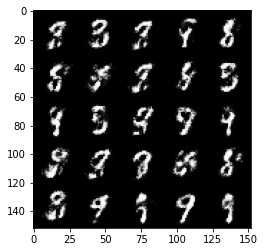

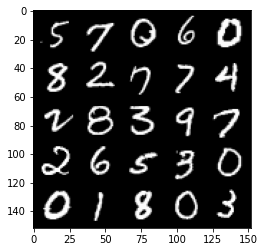

Step 24500: Generator loss: 2.867477033615112, discriminator loss: 0.20851367783546476


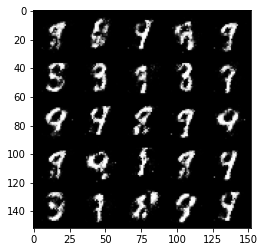

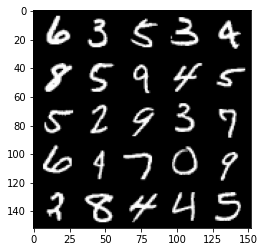

Step 25000: Generator loss: 2.8237906050682087, discriminator loss: 0.20244356276094938


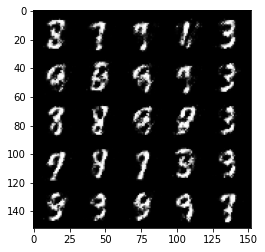

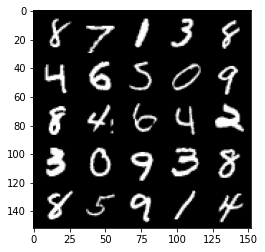

Step 25500: Generator loss: 2.7844224624633807, discriminator loss: 0.2093360995799302


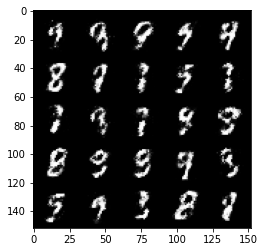

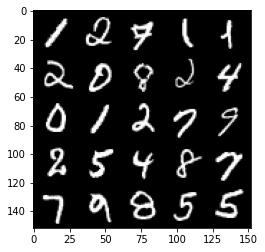

Step 26000: Generator loss: 2.713203273296356, discriminator loss: 0.21702624943852433


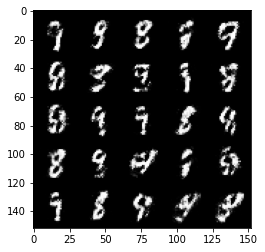

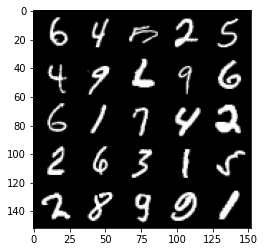

Step 26500: Generator loss: 2.7361227655410767, discriminator loss: 0.20416290684044347


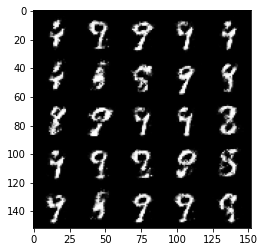

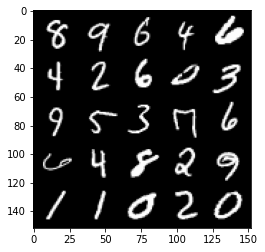

Step 27000: Generator loss: 2.6870368189811695, discriminator loss: 0.20768050736188912


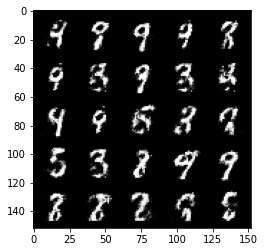

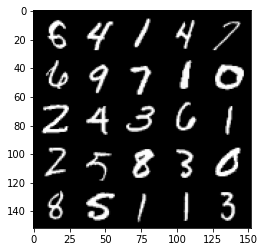

Step 27500: Generator loss: 2.783130222320559, discriminator loss: 0.19876448796689505


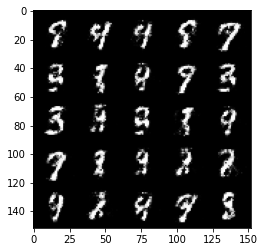

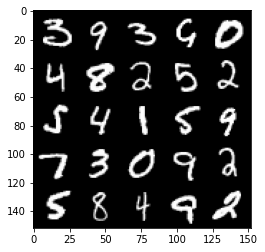

Step 28000: Generator loss: 2.6348579864501946, discriminator loss: 0.23414519473910297


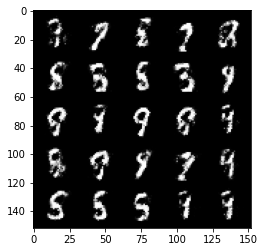

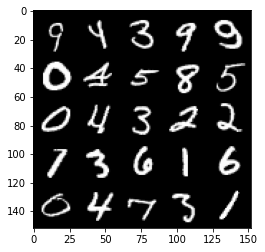

In [21]:
cur_step = 0
mean_generator_loss = 0
test_generator = True
gen_loss = False
mean_discriminator_loss = 0

for epoch in range(2000):
  for real,_ in tqdm(dataloader):
    cur_batch_size = len(real)
    real = real.view(cur_batch_size,-1).to(device)
    disc_opt.zero_grad()
    disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, z_dim, device)
    disc_loss.backward()
    disc_opt.step()


    gen_opt.zero_grad()
    gen_loss = get_gen_loss(gen, disc, criterion, cur_batch_size, z_dim, device)
    gen_loss.backward()
    gen_opt.step()

    mean_discriminator_loss += disc_loss.item() / display_step
    mean_generator_loss += gen_loss.item() / display_step

    if cur_step % display_step == 0 and cur_step > 0:
        print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        fake = gen(fake_noise)
        show_tensor_images(fake)
        show_tensor_images(real)
        mean_generator_loss = 0
        mean_discriminator_loss = 0
    cur_step += 1